# Analyze Region 3 - Arctic Canada North

This notebook analyzes the largest glaciers, ice caps, and ice fields in Region 3 - Arctic Canada North.

This region was deemed as needing a glacier complex analysis (ice caps and icefields), so note that the abbreviation "ic" stands for ice catchment aka glacier complex.

In [1]:
import os
import os.path as op
import glob
import sys
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio as rio
from rasterio.plot import plotting_extent
from earthpy import clip as cl
import earthpy.plot as ep

# set working dir
HOME = op.join(op.expanduser("~"))
os.chdir(os.path.join(HOME, "git/wgms-glacier-project"))

# Set up path to load scripts
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import scripts.wgms_scripts as ws

# Set Up Region Info

In [2]:
# Set region number, region name, and region index
# Once these are set, this notebook should run automatically for the specified region
region_number = "3"
region_name = "Arctic Canada North"

# 3/5/22 - This variable has been deemed unnecessary for this data set so it has been commented out
# The variable primeclass needs to be updated with the primary class of the ice complexes for the region
# This may need to be a list in some instances
# 2: icefield, 3: ice cap, 4: outlet glacier, 5: valley glacier, 6: mountain glacier
#primeclass = 4 # For the largest glacier, this was set in the GLIMS database, I used it for the 2nd and 3rd largest as well

# Note for the region index, region_index_1 should be one less than the region number and 
# region_index_2 should be equal to the region number. For example, for region 1, index_1 should be set to 0 and 
# index_2 should be set to 1, etc.
region_index_1 = 2
region_index_2 = 3

# Ice cap/icefield epsg code used for calculating area
#ic_epsg = '3347'

# This variable sets a value to determine whether the differences between the GLIMS and RGI glacier have been checked.
# When first starting a new notebook set handled to 0
# Once the differences have been checked and handled, set to 1 to pass the check
handled = 1

# * * * * * * * * Show Region Outline * * * * * * * *

In [3]:
# Open natural earth basemap TIF file
ne_fp = 'data/natural-earth/NE1_HR_LC_SR_W/NE1_HR_LC_SR_W.tif' # 10 m res
with rio.open(ne_fp) as ne_src:
    # Convert / read the data into a numpy array:
    ne_raster = ne_src.read()
    ne_src_extent = plotting_extent(ne_src)
    bounds = ne_src.bounds
    ne_raster_meta = ne_src.meta

In [4]:
# Open glacier regions
glacier_regions_fp = "data/gtn-g-glacier-regions/cleaned/GTN-G_glacier_regions_201707_cleaned.shp"
glacier_regions = gpd.read_file(glacier_regions_fp)

# Extract Region outline
region_outline = glacier_regions[region_index_1:region_index_2]

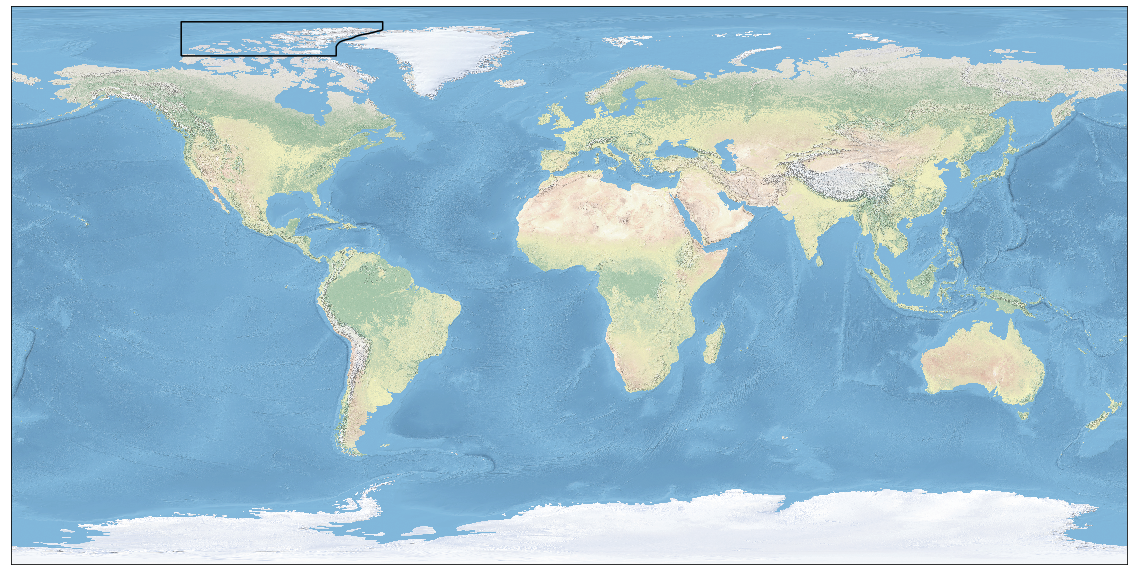

In [5]:
# Plot region outline over the natural earth
# Plot natural earth basemap
fig, ax = plt.subplots(figsize=(20, 20))

# Plot natural earth
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot region outline
region_outline.boundary.plot(ax=ax, color="black")

plt.show()

In [6]:
region_outline.bounds

,minx,miny,maxx,maxy
2,-125.0,74.0,-60.0,85.0


# * * * * * * * * Glacier Analysis * * * * * * * *

## Open GLIMS 3 Largest Glaciers Data

In [7]:
# Open GLIMS three largest glacier outlines for this region.
glims_glaciers_fn = "data/glims/processed/largest/glims_region_" + region_number + "_largest.shp"
glims_glaciers_df = gpd.read_file(glims_glaciers_fn)

In [8]:
# Check if GLIMS glacier names are of the "NoneType" because can't print legends and such if they are
# If they are, set them to a string "NONE"
glims_df_len = len(glims_glaciers_df)
for x in range(glims_df_len):
    if glims_glaciers_df['glac_name'][x] == None:
        print("GLIMS glacier " + str(x) + " equals none")
        glims_glaciers_df.loc[x, 'glac_name'] = 'NONE'

In [9]:
glims_glaciers_df

,region_no,glac_id,area,db_area,width,length,primeclass,min_elev,mean_elev,max_elev,src_date,glac_name,geometry
0,3,G280449E77998N,3263.95,3266.43,0.0,0.0,4.0,0.0,0.0,0.0,1999-07-09T00:00:00,None,"POLYGON Z ((-78.219859 77.972622 0, -78.224275..."
1,3,G278488E75058N,2622.81,2622.81,0.0,0.0,0.0,0.0,0.0,0.0,1999-06-15T00:00:00,None,"POLYGON Z ((-81.502932 75.316999 0, -81.481840..."
2,3,G276805E75127N,2170.55,2170.55,0.0,0.0,0.0,0.0,0.0,0.0,1999-06-15T00:00:00,None,"POLYGON Z ((-82.555437 75.34082100000001 0, -8..."
3,3,G280783E77677N,1890.61,1891.12,0.0,0.0,2.0,0.0,0.0,0.0,1999-07-09T00:00:00,None,"(POLYGON Z ((-78.219373 77.747365 0, -78.20402..."
4,3,G274800E74935N,1780.45,1780.65,0.0,0.0,0.0,0.0,0.0,0.0,1999-06-15T00:00:00,None,"POLYGON Z ((-86.136059 74.790851 0, -86.137223..."


## Open RGI 3 Largest Glaciers Data

In [10]:
# Open RGI three largest glacier outlines for this region.
rgi_glaciers_fn = "data/rgi/processed/largest/rgi_region_" + region_number + "_largest.shp"
rgi_glaciers_df = gpd.read_file(rgi_glaciers_fn)

In [11]:
# Check if RGI glacier names are of the "NoneType" because can't print legends and such if they are
# If they are, set them to a string "NONE"
rgi_df_len = len(rgi_glaciers_df)
for x in range(rgi_df_len):
    if rgi_glaciers_df['Name'][x] == None:
        print("RGI glacier " + str(x) + " equals none")
        rgi_glaciers_df.loc[x, 'Name'] = 'NONE'

RGI glacier 2 equals none
RGI glacier 4 equals none


In [12]:
rgi_glaciers_df

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
0,RGI60-03.01710,G280449E77998N,19999999,20039999,-79.5510,77.9980,3,4,3085.113,0,...,102,81426,0,0,0,1,3,9,Wykeham Glacier South,POLYGON ((-79.53182996399994 78.42253806900004...
1,RGI60-03.02467,G278488E75058N,19999999,20009999,-81.5122,75.0577,3,6,2622.813,0,...,128,82582,0,0,1,1,1,9,Devon Ice Cap Southeast2 Glacier,POLYGON ((-81.50293176099996 75.31699918000004...
2,RGI60-03.02489,G276805E75127N,19999999,20009999,-83.1946,75.1273,3,6,2170.549,1,...,212,70518,0,0,1,1,0,9,NONE,POLYGON ((-82.55543658499994 75.34082067100007...
3,RGI60-03.01678,G280783E77677N,19999999,20039999,-79.2170,77.6770,3,4,1892.023,0,...,108,85129,0,0,0,1,3,9,Easter Island South,POLYGON ((-79.55158695499995 77.81187922500004...
4,RGI60-03.01466,G274800E74935N,19999999,20009999,-85.1996,74.9351,3,6,1780.453,234,...,276,17684,0,0,0,0,0,9,NONE,POLYGON ((-86.13605894499995 74.79085143200007...


## Plot GLIMS Glaciers

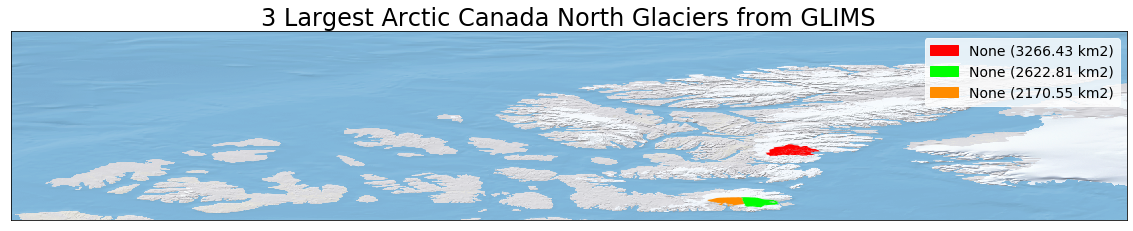

In [13]:
# Plot 3 largest glaciers on natural earth from GLIMS
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [glims_glaciers_df['glac_name'][0] + ' (' + str(glims_glaciers_df['db_area'][0]) + ' km2)',
                 glims_glaciers_df['glac_name'][1] + ' (' + str(glims_glaciers_df['db_area'][1]) + ' km2)',
                 glims_glaciers_df['glac_name'][2] + ' (' + str(glims_glaciers_df['db_area'][2]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
glims_glaciers_df.iloc[0:1].plot(ax=ax, color='red')
glims_glaciers_df.iloc[1:2].plot(ax=ax, color='lime')
glims_glaciers_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers from GLIMS', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

## Plot RGI Glaciers

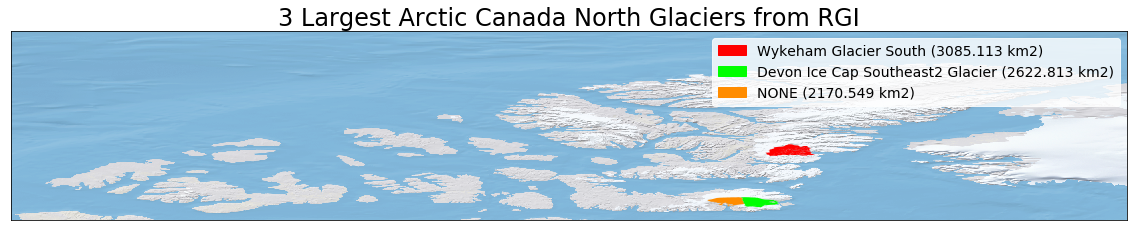

In [14]:
# Plot 3 largest glaciers on natural earth from RGI
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [rgi_glaciers_df['Name'][0] + ' (' + str(rgi_glaciers_df['Area'][0]) + ' km2)',
                 rgi_glaciers_df['Name'][1] + ' (' + str(rgi_glaciers_df['Area'][1]) + ' km2)',
                 rgi_glaciers_df['Name'][2] + ' (' + str(rgi_glaciers_df['Area'][2]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from rgi dataframe
rgi_glaciers_df.iloc[0:1].plot(ax=ax, color='red')
rgi_glaciers_df.iloc[1:2].plot(ax=ax, color='lime')
rgi_glaciers_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers from RGI', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

## Compare Glaciers from GLIMS and RGI
Do they match? If yes, continue, if no, stop notebook and investigate. Once the differences have been investigated and corrected in the code below this code block, set handled to 1 in the "Set Up Region Info" section at the top of the notebook, so that it passes this test.

In [15]:
if (glims_glaciers_df['glac_name'][0] == rgi_glaciers_df['Name'][0] and 
    glims_glaciers_df['glac_name'][1] == rgi_glaciers_df['Name'][1] and 
    glims_glaciers_df['glac_name'][2] == rgi_glaciers_df['Name'][2]):
    print("They match!")
else:
    if handled != 1:
        # If this hasn't been handled, stop execution
        class StopExecution(Exception):
            def _render_traceback_(self):
                pass

        print("They do NOT Match! Stopping notebook.")
        raise StopExecution
    else:
        # If this has been handled, continue execution
        print("They do not match but this has been handled in the code below this section, so continue.")

They do not match but this has been handled in the code below this section, so continue.


## Create Final Glacier Shapefiles
This section creates and formats the final glacier dataframe, plots it to make sure it looks ok, and saves it to a shapefile.

### Create final glacier dataframe

In [16]:
# Set up the final dataframe that will be used when saving the final shapefiles
# Drop columns that are not needed for the final data (use GLIMS dataframe for this)
final_glacier_data_df = glims_glaciers_df.drop(['area', 'width', 'length', 
                                                'min_elev', 'mean_elev', 'max_elev'], axis=1)

# Add region_name column
final_glacier_data_df['reg_name'] = region_name

# Rename some columns
final_glacier_data_df.rename(columns={'glac_id': 'glims_id', 'db_area': 'area_km2', 
                                       'src_date': 'date'}, inplace=True)

# Drop last 2 rows because they are the fourth and fifthe largest glaciers and we aren't interested in them
final_glacier_data_df.drop([3, 4], inplace = True)

# Add RGI ID column
final_glacier_data_df['rgi_id'] = (rgi_glaciers_df['RGIId'][0], rgi_glaciers_df['RGIId'][1], 
                                   rgi_glaciers_df['RGIId'][2])

# Add area_src column that gets filled lower down
final_glacier_data_df['area_src'] = '-999'

# Reorder the columns of the dataframe
final_glacier_data_df = final_glacier_data_df[['region_no', 'reg_name', 'glac_name', 'glims_id', 'rgi_id',
                                               'area_km2', 'area_src', 'date', 'geometry']]

In [17]:
final_glacier_data_df

,region_no,reg_name,glac_name,glims_id,rgi_id,area_km2,area_src,date,geometry
0,3,Arctic Canada North,None,G280449E77998N,RGI60-03.01710,3266.43,-999,1999-07-09T00:00:00,"POLYGON Z ((-78.219859 77.972622 0, -78.224275..."
1,3,Arctic Canada North,None,G278488E75058N,RGI60-03.02467,2622.81,-999,1999-06-15T00:00:00,"POLYGON Z ((-81.502932 75.316999 0, -81.481840..."
2,3,Arctic Canada North,None,G276805E75127N,RGI60-03.02489,2170.55,-999,1999-06-15T00:00:00,"POLYGON Z ((-82.555437 75.34082100000001 0, -8..."


In [18]:
# Calculate area and update dataframe as neccessary and clean the date format in the date column
# If GLIMS and RGI dates are the same year, then average the two areas.
# If GLIMS date is more recent, then use that average.
# If RGI date is more recent, then use that average. (Note I don't think this ever happens)
# Note only comparing by year because sometimes the month and day are not known. Year matching is close enough.
for x in range(3):
    # Exract and clean GLIMS date so that it is comparable to RGI date
    glims_date = glims_glaciers_df['src_date'][x][0:10].replace('-', '')
    glims_year = glims_date[0:4]
    print('glims date: ' + glims_date)
    #print('glims year: ' + glims_year)
    
    # Extract RGI date
    rgi_date = rgi_glaciers_df['BgnDate'][x]
    rgi_year = rgi_date[0:4]
    print('rgi date: ' + rgi_date)
    #print('rgi year: ' + rgi_year)
    
    if glims_year == rgi_year:
        # Average GLIMS and RGI areas
        area = np.average([glims_glaciers_df['db_area'][x], rgi_glaciers_df['Area'][x]])
        area_src = 'A'
        print('Averaging area: ' + str(area))
    elif glims_year > rgi_year:
        # Use GLIMS area for the area
        area = glims_glaciers_df['db_area'][x]
        area_src = 'G'
        print('Using GLIMS area: ' + str(area))
    elif rgi_year > glims_year:
        # Use RGI area for the area
        area = rgi_glaciers_df['Area'][x]
        area_src = 'R'
        print('Using RGI area: ' + str(area))
    else:
        print("Error. Area could not be calculated.")
    
    print('')
    # Set the area in the final dataframe
    final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('area_km2')] = area
    final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('area_src')] = area_src
    
    # Clean the date format in the final dataframe
    final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('date')] = glims_glaciers_df['src_date'][x][0:10]
    
    # Use the glacier names from RGI for the final data df
    if x == 0:
        # Simply set the final df name to the rgi name
        final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('glac_name')] = rgi_glaciers_df['Name'][x]
    if x == 1:
        # Clean up the Devon Ice Cap Southeast glacier name
        final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('glac_name')] = \
        rgi_glaciers_df['Name'][x].replace("2 Glacier", " Glacier No. 2")
    if x == 2:
        # Set this name to Crocker Bay Glacier per Wyatt and Sharp(2015)
        final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('glac_name')] = 'Croker Bay Glacier'

glims date: 19990709
rgi date: 19999999
Averaging area: 3175.7715

glims date: 19990615
rgi date: 19999999
Averaging area: 2622.8115

glims date: 19990615
rgi date: 19999999
Averaging area: 2170.5495



In [19]:
# Find the centroid of the glacier and add the lat/lon to the dataframe
centroidseries_gl = final_glacier_data_df['geometry'].centroid
    
final_glacier_data_df['cenlat'] = [centroidseries_gl.geometry.y[0], centroidseries_gl.geometry.y[1], 
                                   centroidseries_gl.geometry.y[2]]
final_glacier_data_df['cenlon'] = [centroidseries_gl.geometry.x[0], centroidseries_gl.geometry.x[1], 
                                   centroidseries_gl.geometry.x[2]]

# Reorder the columns of the dataframe
final_glacier_data_df = final_glacier_data_df[['region_no', 'reg_name', 'glac_name', 'glims_id', 'rgi_id', 
                                'area_km2', 'area_src', 'date', 'cenlat', 'cenlon', 'geometry']]

In [20]:
final_glacier_data_df

,region_no,reg_name,glac_name,glims_id,rgi_id,area_km2,area_src,date,cenlat,cenlon,geometry
0,3,Arctic Canada North,Wykeham Glacier South,G280449E77998N,RGI60-03.01710,3175.7715,A,1999-07-09,78.050991,-79.538784,"POLYGON Z ((-78.219859 77.972622 0, -78.224275..."
1,3,Arctic Canada North,Devon Ice Cap Southeast Glacier No. 2,G278488E75058N,RGI60-03.02467,2622.8115,A,1999-06-15,75.057659,-81.512226,"POLYGON Z ((-81.502932 75.316999 0, -81.481840..."
2,3,Arctic Canada North,Croker Bay Glacier,G276805E75127N,RGI60-03.02489,2170.5495,A,1999-06-15,75.127298,-83.194622,"POLYGON Z ((-82.555437 75.34082100000001 0, -8..."


### Plot final glacier dataframe to check accuracy

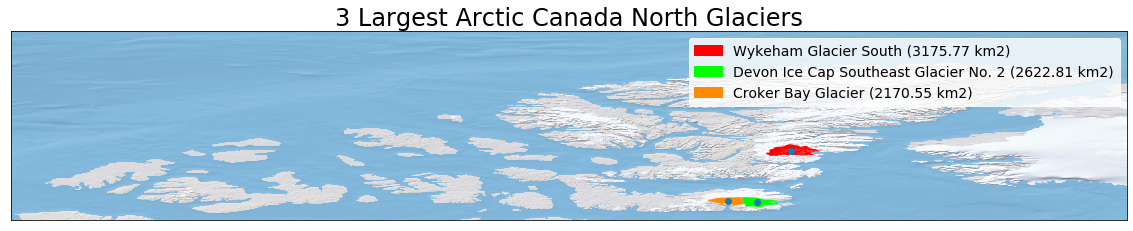

In [21]:
# Check that the geodataframe wasn't corrupted from these changes by plotting the data
# Plot 3 largest glaciers on natural earth from GLIMS
# Set up legend. Note that the sizes come from an average of GLIMS and RGI. 
# See wgms-glacier-project/data/comparison/compare-glims-rgi.xlsx
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [final_glacier_data_df['glac_name'][0] + \
                 ' (' + str(round(final_glacier_data_df['area_km2'][0], 2)) + ' km2)',
                 final_glacier_data_df['glac_name'][1] + \
                 ' (' + str(round(final_glacier_data_df['area_km2'][1], 2)) + ' km2)',
                 final_glacier_data_df['glac_name'][2] + \
                 ' (' + str(round(final_glacier_data_df['area_km2'][2], 2)) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
final_glacier_data_df.iloc[0:1].plot(ax=ax, color='red')
final_glacier_data_df.iloc[1:2].plot(ax=ax, color='lime')
final_glacier_data_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers', fontsize=24)

# Plot the center points of the glacier complexes
centroidseries_gl.plot(ax=ax)

# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

### Create largest glacier shapefile from the final glacier dataframe

In [22]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
glacier_zipfile_fn = "data/final-dataset/region-" + region_number + "-largest-glaciers.zip"
if os.path.exists(glacier_zipfile_fn) == False:
    # Create the shapefile
    final_glacier_data_fn = "data/final-dataset/region-" + region_number + "-largest-glaciers.shp"
    final_glacier_data_df.to_file(driver='ESRI Shapefile', filename=final_glacier_data_fn)
    
    # Zip up the shapefile
    glacier_zipfile_fn = ws.zipshp(final_glacier_data_fn, Delete=True)
    print("Creating zipfile: " + glacier_zipfile_fn)
else:
    print(glacier_zipfile_fn + " already extists")

Creating zipfile: data/final-dataset\region-3-largest-glaciers.zip


# * * * * * * * * Ice Cap Analysis * * * * * * * *

April 17, 2021: Decided to merge ice cap/ice field sections so there’s only the top three of them combined instead of doing the top 3 ice caps and also the top 3 ice fields. So updating code to just select the largest 3 ice caps/icefields in region 3.

In [23]:
# Open this regions ice caps from the exploded version
ice_caps_ex_fn = "data/glims/processed/ice-caps/largest/largest-ice-caps-region_" + region_number + "_laea.shp"
ice_caps_ex_df = gpd.read_file(ice_caps_ex_fn)

In [24]:
ice_caps_ex_df

,id,area,geometry
0,13,19521.345090,"POLYGON ((-80.798525 81.250319, -80.793099 81...."
1,9,19009.221811,"POLYGON ((-80.374956 77.30712200000001, -80.37..."
2,15,18037.989024,"POLYGON ((-74.264652 79.611407, -74.2605049999..."
3,1,13909.681244,POLYGON ((-81.72486000000001 74.56395999999999...
4,8,7837.861870,POLYGON ((-88.52648499999999 78.96548900000001...
5,2,5311.853581,"POLYGON ((-80.81959999999999 76.21677, -80.824..."
6,937,2763.204043,"POLYGON ((-91.178678 78.33252, -91.18216099999..."
7,444,2634.427570,"POLYGON ((-85.331221 76.470753, -85.33386 76.4..."
8,7,1810.523538,"POLYGON ((-79.291584 79.236374, -79.282926 79...."
9,1690,1665.672784,"POLYGON ((-84.797616 80.837233, -84.800308 80...."


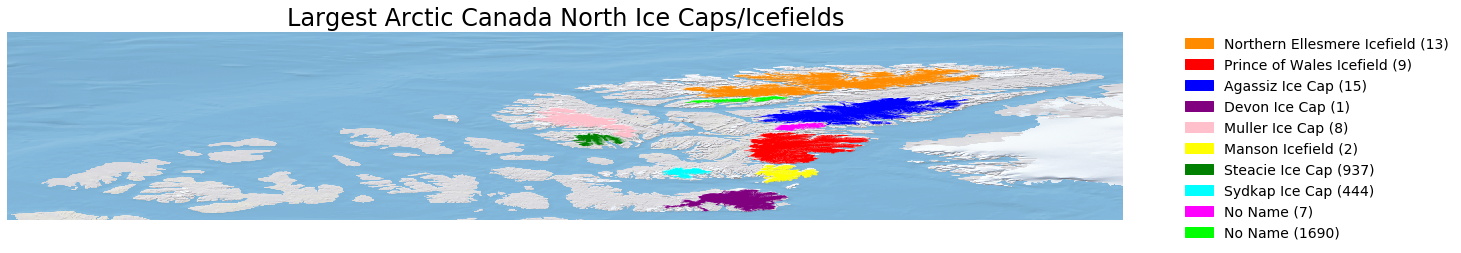

In [25]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['darkorange', 'red', 'blue', 'purple', 'pink', 'yellow', 'green', 'cyan', 'magenta', 'lime']
legend_labels = ['Northern Ellesmere Icefield (13)', 'Prince of Wales Icefield (9)', 'Agassiz Ice Cap (15)', 
                 'Devon Ice Cap (1)', 'Muller Ice Cap (8)', 'Manson Icefield (2)', 'Steacie Ice Cap (937)', 
                 'Sydkap Ice Cap (444)', 'No Name (7)', 'No Name (1690)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
ice_caps_ex_df.iloc[0:1].plot(ax=ax, color="darkorange")
ice_caps_ex_df.iloc[1:2].plot(ax=ax, color="red")
ice_caps_ex_df.iloc[2:3].plot(ax=ax, color="blue")
ice_caps_ex_df.iloc[3:4].plot(ax=ax, color="purple")
ice_caps_ex_df.iloc[4:5].plot(ax=ax, color="pink")
ice_caps_ex_df.iloc[5:6].plot(ax=ax, color="yellow")
ice_caps_ex_df.iloc[6:7].plot(ax=ax, color="green")
ice_caps_ex_df.iloc[7:8].plot(ax=ax, color="cyan")
ice_caps_ex_df.iloc[8:9].plot(ax=ax, color="magenta")
ice_caps_ex_df.iloc[9:10].plot(ax=ax, color="lime")
ax.set_title('Largest ' + region_name + ' Ice Caps/Icefields', fontsize=24)
ax.set_axis_off()

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

## Create Final Ice Catchment Data Frame
This ice catchment data frame will then be saved to a shapefile.

In [26]:
# Update and reorganize ice_caps_ex_df to create final df
# Drop uneeded columns
final_catchment_data_df = ice_caps_ex_df.drop(['id'], axis=1)

# Drop last 7 rows because only interested in the top 3 ice caps/icefields
final_catchment_data_df.drop([3, 4, 5, 6, 7, 8, 9], inplace = True)

# Add region_no column
final_catchment_data_df['region_no'] = region_number

# Add region_name column
final_catchment_data_df['reg_name'] = region_name

# Add catchment names
final_catchment_data_df['ic_name'] = ['Northern Ellesmere Icefield', 'Prince of Wales Icefield', 'Agassiz Ice Cap'] 
                                      # 'Devon Ice Cap', 'Müller Ice Cap', 'Manson Icefield']

### Get ice catchment GLIMS IDs and measurement dates from a range of glacier outline dates.

In [27]:
# Open GLIMS shapefile with all of the glacier outlines
glims_all_glaciers_fn = "data/glims/processed/cleaned/glims_region_" + region_number + "_cleaned.shp"
glims_all_glaciers_df = gpd.read_file(glims_all_glaciers_fn)

In [28]:
# The call to the pip function can take a couple of minutes to many hours to run depending on the complexity and size
# of the ice catchment outline. I set up the code to save the output to shapefiles that can be read in more quickly
# if desired. However, you can toggle whether you read the files or run the pip command with the following variable.
# Note that you must run the pip command the first time this code is run in order to create the shapefiles.
run_code = 0 # set to 0 to read from saved shapefiles, set to 1 to run pip command and create shapefiles

# Get glaciers in the 1st largest glacier complex
if run_code == 1: # run pip command
    largest_ic_1_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[0:1].reset_index(drop=True))
    largest_ic_1_glaciers = glims_all_glaciers_df.loc[largest_ic_1_mask]
    largest_ic_1_glaciers.reset_index(drop=True, inplace=True)
elif run_code == 0: # read saved shapefiles
    ic_1_glaciers_zfn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                        region_number + "-1st-largest-ic-glacier-outlines.zip"
    with zipfile.ZipFile(ic_1_glaciers_zfn,"r") as zip_ref:
        zip_ref.extractall("data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped")

    ic_1_glaciers_shape_fn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-" + \
                                  region_number + "-1st-largest-ic-glacier-outlines.shp"
    largest_ic_1_glaciers = gpd.read_file(ic_1_glaciers_shape_fn)
    print("Reading file " + ic_1_glaciers_shape_fn)

    # Clean up unzipped files to save disk space
    filelist = glob.glob("data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/*")
    for f in filelist:
        os.remove(f)
else:
    print("Incorrect value for the run_code variable. Must be 0 or 1.")

# Clean and print the minimum date and the maximum date
largest_ic_1_min_date = largest_ic_1_glaciers['src_date'].min()[0:10]
largest_ic_1_max_date = largest_ic_1_glaciers['src_date'].max()[0:10]
print('1st largest start date: ' + largest_ic_1_min_date)
print('1st largest end date: ' + largest_ic_1_max_date)
print('')

# Get all glims ids that make up the 1st largest ice catchment
largest_ic_1_glims_ids = largest_ic_1_glaciers['glac_id']
for i in range(len(largest_ic_1_glims_ids)):
    if i == 0:
        all_largest_ic_1_ids = largest_ic_1_glims_ids[i]
    else:
        all_largest_ic_1_ids = all_largest_ic_1_ids + ', ' + largest_ic_1_glims_ids[i]

# Get glaciers in the 2nd largest glacier complex
if run_code == 1: # run pip command
    largest_ic_2_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[1:2].reset_index(drop=True), buffer_val=.01)
    largest_ic_2_glaciers = glims_all_glaciers_df.loc[largest_ic_2_mask]
    largest_ic_2_glaciers.reset_index(drop=True, inplace=True)
elif run_code == 0: # read saved shapefiles
    ic_2_glaciers_zfn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                        region_number + "-2nd-largest-ic-glacier-outlines.zip"
    with zipfile.ZipFile(ic_2_glaciers_zfn,"r") as zip_ref:
        zip_ref.extractall("data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped")

    ic_2_glaciers_shape_fn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-" + \
                                  region_number + "-2nd-largest-ic-glacier-outlines.shp"
    largest_ic_2_glaciers = gpd.read_file(ic_2_glaciers_shape_fn)
    print("Reading file " + ic_2_glaciers_shape_fn)

    # Clean up unzipped files to save disk space
    filelist = glob.glob("data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/*")
    for f in filelist:
        os.remove(f)
else:
    print("Incorrect value for the run_code variable. Must be 0 or 1.")

# Clean and print the minimum date and the maximum date
largest_ic_2_min_date = largest_ic_2_glaciers['src_date'].min()[0:10]
largest_ic_2_max_date = largest_ic_2_glaciers['src_date'].max()[0:10]
print('2nd largest start date: ' + largest_ic_2_min_date)
print('2nd largest end date: ' + largest_ic_2_max_date)
print('')

# Get all glims ids that make up the 2nd largest ice catchment
largest_ic_2_glims_ids = largest_ic_2_glaciers['glac_id']
for i in range(len(largest_ic_2_glims_ids)):
    if i == 0:
        all_largest_ic_2_ids = largest_ic_2_glims_ids[i]
    else:
        all_largest_ic_2_ids = all_largest_ic_2_ids + ', ' + largest_ic_2_glims_ids[i]


# Get glaciers in the 3rd largest glacier complex
if run_code == 1: # run pip command
    largest_ic_3_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[2:3].reset_index(drop=True))
    largest_ic_3_glaciers = glims_all_glaciers_df.loc[largest_ic_3_mask]
    largest_ic_3_glaciers.reset_index(drop=True, inplace=True)
elif run_code == 0: # read saved shapefiles
    ic_3_glaciers_zfn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                        region_number + "-3rd-largest-ic-glacier-outlines.zip"
    with zipfile.ZipFile(ic_3_glaciers_zfn,"r") as zip_ref:
        zip_ref.extractall("data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped")

    ic_3_glaciers_shape_fn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-" + \
                                  region_number + "-3rd-largest-ic-glacier-outlines.shp"
    largest_ic_3_glaciers = gpd.read_file(ic_3_glaciers_shape_fn)
    print("Reading file " + ic_3_glaciers_shape_fn)

    # Clean up unzipped files to save disk space
    filelist = glob.glob("data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/*")
    for f in filelist:
        os.remove(f)
else:
    print("Incorrect value for the run_code variable. Must be 0 or 1.")

# Clean and print the minimum date and the maximum date
largest_ic_3_min_date = largest_ic_3_glaciers['src_date'].min()[0:10]
largest_ic_3_max_date = largest_ic_3_glaciers['src_date'].max()[0:10]
print('3rd largest start date: ' + largest_ic_3_min_date)
print('3rd largest end date: ' + largest_ic_3_max_date)
print('')

# Get all glims ids that make up the 3rd largest ice catchment
largest_ic_3_glims_ids = largest_ic_3_glaciers['glac_id']
for i in range(len(largest_ic_3_glims_ids)):
    if i == 0:
        all_largest_ic_3_ids = largest_ic_3_glims_ids[i]
    else:
        all_largest_ic_3_ids = all_largest_ic_3_ids + ', ' + largest_ic_3_glims_ids[i]

# Get glaciers in the Devon Ice Cap
#devon_ic_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[3:4].reset_index(drop=True))
#devon_glaciers = glims_all_glaciers_df.loc[devon_ic_mask]

# Clean and print the minimum date and the maximum date
#devon_glaciers_min_date = devon_glaciers['src_date'].min()[0:10]
#devon_glaciers_max_date = devon_glaciers['src_date'].max()[0:10]
#print('devon start date: ' + devon_glaciers_min_date)
#print('devon end date: ' + devon_glaciers_max_date)
#print('')

# Get glaciers in the Muller Ice Cap
#muller_ic_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[4:5].reset_index(drop=True))
#muller_glaciers = glims_all_glaciers_df.loc[muller_ic_mask]

# Clean and print the minimum date and the maximum date
#muller_glaciers_min_date = muller_glaciers['src_date'].min()[0:10]
#muller_glaciers_max_date = muller_glaciers['src_date'].max()[0:10]
#print('muller start date: ' + muller_glaciers_min_date)
#print('muller end date: ' + muller_glaciers_max_date)
#print('')

# Get glaciers in the Manson icefield
#manson_ic_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[5:6].reset_index(drop=True))
#manson_glaciers = glims_all_glaciers_df.loc[manson_ic_mask]

# Clean and print the minimum date and the maximum date
#manson_glaciers_min_date = manson_glaciers['src_date'].min()[0:10]
#manson_glaciers_max_date = manson_glaciers['src_date'].max()[0:10]
#print('manson start date: ' + manson_glaciers_min_date)
#print('manson end date: ' + manson_glaciers_max_date)

Reading file data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-3-1st-largest-ic-glacier-outlines.shp
1st largest start date: 1999-06-15
1st largest end date: 1999-06-15

Reading file data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-3-2nd-largest-ic-glacier-outlines.shp
2nd largest start date: 1999-06-15
2nd largest end date: 1999-07-09

Reading file data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-3-3rd-largest-ic-glacier-outlines.shp
3rd largest start date: 1999-06-15
3rd largest end date: 1999-06-15



In [29]:
# Find the centroid of the glacier complex and add the lat/lon to the dataframe
centroidseries = final_catchment_data_df['geometry'].centroid

In [30]:
# Add the dates to the dataframe
final_catchment_data_df['min_date'] = [largest_ic_1_min_date, largest_ic_2_min_date, largest_ic_3_min_date]

final_catchment_data_df['max_date'] = [largest_ic_1_max_date, largest_ic_2_max_date, largest_ic_3_max_date]

# Add lat/lon
final_catchment_data_df['cenlat'] = [centroidseries.geometry.y[0], centroidseries.geometry.y[1], 
                                     centroidseries.geometry.y[2]]
final_catchment_data_df['cenlon'] = [centroidseries.geometry.x[0], centroidseries.geometry.x[1], 
                                     centroidseries.geometry.x[2]]

# Reorder the columns
final_catchment_data_df = final_catchment_data_df[['region_no', 'reg_name', 'ic_name', 'area', 
                                                   'min_date', 'max_date', 'cenlat', 'cenlon', 'geometry']]

# Rename the area column
final_catchment_data_df.rename(columns={'area': 'area_km2'}, inplace=True)
                                     
# Reset index
final_catchment_data_df = final_catchment_data_df.reset_index(drop=True)

In [31]:
final_catchment_data_df

,region_no,reg_name,ic_name,area_km2,min_date,max_date,cenlat,cenlon,geometry
0,3,Arctic Canada North,Northern Ellesmere Icefield,19521.345090,1999-06-15,1999-06-15,81.995903,-77.040312,"POLYGON ((-80.798525 81.250319, -80.793099 81...."
1,3,Arctic Canada North,Prince of Wales Icefield,19009.221811,1999-06-15,1999-07-09,78.273817,-78.980591,"POLYGON ((-80.374956 77.30712200000001, -80.37..."
2,3,Arctic Canada North,Agassiz Ice Cap,18037.989024,1999-06-15,1999-06-15,80.337616,-75.300268,"POLYGON ((-74.264652 79.611407, -74.2605049999..."


### Plot the final catchment dataframe to verify it looks correct

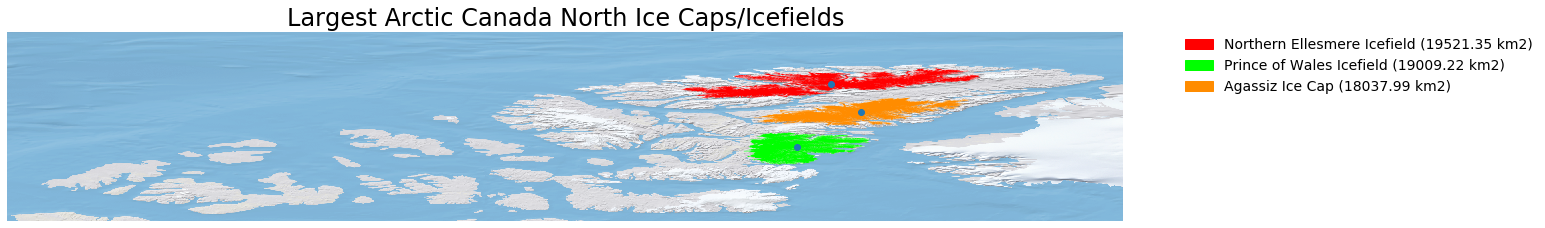

In [32]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['red', 'lime', 'darkorange'] #, 'purple', 'pink', 'yellow']
legend_labels = [final_catchment_data_df['ic_name'][0] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][0], 2)) + ' km2)', 
                 final_catchment_data_df['ic_name'][1] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][1], 2)) + ' km2)', 
                 final_catchment_data_df['ic_name'][2] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][2], 2)) + ' km2)'] 
                 #final_catchment_data_df['ic_name'][3] + \
                 #' (' + str(round(final_catchment_data_df['area_km2'][3], 2)) + ' km2)', 
                 #final_catchment_data_df['ic_name'][4] + \
                 #' (' + str(round(final_catchment_data_df['area_km2'][4], 2)) + ' km2)', 
                 #final_catchment_data_df['ic_name'][5] + \
                 #' (' + str(round(final_catchment_data_df['area_km2'][5], 2)) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
final_catchment_data_df.iloc[0:1].plot(ax=ax, color="red")
final_catchment_data_df.iloc[1:2].plot(ax=ax, color="lime")
final_catchment_data_df.iloc[2:3].plot(ax=ax, color="darkorange")
#final_catchment_data_df.iloc[3:4].plot(ax=ax, color="purple")
#final_catchment_data_df.iloc[4:5].plot(ax=ax, color="pink")
#final_catchment_data_df.iloc[5:6].plot(ax=ax, color="yellow")
ax.set_title('Largest ' + region_name + ' Ice Caps/Icefields', fontsize=24)
ax.set_axis_off()

# Plot the center points of the glacier complexes
centroidseries.plot(ax=ax)

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

### Save final catchment dataframe to a shapefile

In [33]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
catchment_zipfile_fn = "data/final-dataset/region-" + region_number + "-largest-complexes.zip"
if os.path.exists(catchment_zipfile_fn) == False:
    # Create the shapefile
    final_catchment_data_fn = "data/final-dataset/region-" + region_number + "-largest-complexes.shp"
    final_catchment_data_df.to_file(driver='ESRI Shapefile', filename=final_catchment_data_fn)
    
    # Zip up the shapefile
    catchment_zipfile_fn = ws.zipshp(final_catchment_data_fn, Delete=True)
    print("Creating zipfile: " + catchment_zipfile_fn)
else:
    print(catchment_zipfile_fn + " already extists")

Creating zipfile: data/final-dataset\region-3-largest-complexes.zip


In [34]:
# Save the glims ids to a text file because the text is too long to be saved to a shapefile
text_file_1st_fn = "data/final-dataset/region-" + region_number + "-1st-largest-glims-ids.txt"
if os.path.exists(text_file_1st_fn) == False:
    print("Creating text file: " + text_file_1st_fn)
    text_file = open(text_file_1st_fn, "w")
    n = text_file.write(all_largest_ic_1_ids)
    text_file.close()
else:
    print(text_file_1st_fn + " already extists")
    
text_file_2nd_fn = "data/final-dataset/region-" + region_number + "-2nd-largest-glims-ids.txt"
if os.path.exists(text_file_2nd_fn) == False:
    print("Creating text file: " + text_file_2nd_fn)
    text_file = open(text_file_2nd_fn, "w")
    n = text_file.write(all_largest_ic_2_ids)
    text_file.close()
else:
    print(text_file_2nd_fn + " already extists")
    
text_file_3rd_fn = "data/final-dataset/region-" + region_number + "-3rd-largest-glims-ids.txt"
if os.path.exists(text_file_3rd_fn) == False:
    print("Creating text file: " + text_file_3rd_fn)
    text_file = open(text_file_3rd_fn, "w")
    n = text_file.write(all_largest_ic_3_ids)
    text_file.close()
else:
    print(text_file_3rd_fn + " already extists")
    
# Save the glacier outline dataframes from the pip command to shapefiles for easier recall later because sometimes
# the pip command can take hours to run
ic_1_glaciers_zfn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                    region_number + "-1st-largest-ic-glacier-outlines.zip"
if os.path.exists(ic_1_glaciers_zfn) == False:
    # Create the shapefile
    ic_1_glaciers_shape_fn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                              region_number + "-1st-largest-ic-glacier-outlines.shp"
    largest_ic_1_glaciers.to_file(driver='ESRI Shapefile', filename=ic_1_glaciers_shape_fn)
    
    # Zip up the shapefile
    ic_1_glaciers_zfn = ws.zipshp(ic_1_glaciers_shape_fn, Delete=True)
    print("Creating zipfile: " + ic_1_glaciers_zfn)
else:
    print(ic_1_glaciers_zfn + " already extists")
    
ic_2_glaciers_zfn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                    region_number + "-2nd-largest-ic-glacier-outlines.zip"
if os.path.exists(ic_2_glaciers_zfn) == False:
    # Create the shapefile
    ic_2_glaciers_shape_fn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                              region_number + "-2nd-largest-ic-glacier-outlines.shp"
    largest_ic_2_glaciers.to_file(driver='ESRI Shapefile', filename=ic_2_glaciers_shape_fn)
    
    # Zip up the shapefile
    ic_2_glaciers_zfn = ws.zipshp(ic_2_glaciers_shape_fn, Delete=True)
    print("Creating zipfile: " + ic_2_glaciers_zfn)
else:
    print(ic_2_glaciers_zfn + " already extists")
    
ic_3_glaciers_zfn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                    region_number + "-3rd-largest-ic-glacier-outlines.zip"
if os.path.exists(ic_3_glaciers_zfn) == False:
    # Create the shapefile
    ic_3_glaciers_shape_fn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                              region_number + "-3rd-largest-ic-glacier-outlines.shp"
    largest_ic_3_glaciers.to_file(driver='ESRI Shapefile', filename=ic_3_glaciers_shape_fn)
    
    # Zip up the shapefile
    ic_3_glaciers_zfn = ws.zipshp(ic_3_glaciers_shape_fn, Delete=True)
    print("Creating zipfile: " + ic_3_glaciers_zfn)
else:
    print(ic_3_glaciers_zfn + " already extists")

data/final-dataset/region-3-1st-largest-glims-ids.txt already extists
data/final-dataset/region-3-2nd-largest-glims-ids.txt already extists
data/final-dataset/region-3-3rd-largest-glims-ids.txt already extists
data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-3-1st-largest-ic-glacier-outlines.zip already extists
data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-3-2nd-largest-ic-glacier-outlines.zip already extists
data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-3-3rd-largest-ic-glacier-outlines.zip already extists


### Extra Stuff: Checking if pip function needs a buffer
Due to tiny differences in vertices computed from the explode method used to find ice catchments, the pip function doesn't always return all glaceris that should be in that outline. This section analyses what size buffer is needed to capture all glacier outlines that reside in an ice catchment outline.

Only the 2nd largest ice catchment needed a buffer. A buffer value of .01 was optimal. The buffer value was added to the pip call in the code above.

Even after the correct buffer is found, the area from the sum of all the glacier outlines in 2nd largest ice catchment versus the area calculated from the exploded ice catchment didn't exactly match - the area from the sum is larger. This is due to an issue in the orginal GLIMS database where some glacier outlines are included twice but get different glacier ids so they appear to be different outlines even when they are not. So when the sum is calculated those glaciers are getting counted twice. Verified this by using a script written by Bruce Raup called find_overlapping_entities.py.

In [35]:
# Stop execution here. Run extra stuff manually if you want to run this code
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

print("Stopping notebook.")
raise StopExecution

Stopping notebook.


#### Check 1st largest

In [ ]:
fig, ax1 = plt.subplots(figsize=(20, 20))
fig, ax2 = plt.subplots(figsize=(20, 20))

# Plot the catchment outline
final_catchment_data_df.iloc[0:1].boundary.plot(ax=ax1)

# Plot the outlines acquired from pip function
largest_ic_1_glaciers.boundary.plot(ax=ax2)

# Compare area calculated from the catchment outline and the sum of the individual outlines acquired from pip function
print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[0:1][0])
print('Area from sum: ', largest_ic_1_glaciers['db_area'].sum())

# Calculate the difference and print a message based on the magnitude of the difference
area_diff_1 = final_catchment_data_df['area_km2'].iloc[0:1][0] - largest_ic_1_glaciers['db_area'].sum()
if (abs(area_diff_1)) <= .1:
    print("Areas match well! Area difference: ", abs(area_diff_1))
    match1 = 1
else:
    print("*** Areas do not match well. May need to add a buffer. Area difference:", abs(area_diff_1))
    match1 = 0

In [ ]:
# If the areas do not match need to try different buffer values to get best match
fig, ax1 = plt.subplots(figsize=(20, 20))
fig, ax2 = plt.subplots(figsize=(20, 20))

buffer_val = .01
if match1 == 0:
    # Trying a buffer on the within function to see if it captures more of the galcier outliness
    ic_1_explode_outline = ice_caps_ex_df.iloc[0:1].reset_index(drop=True)
    largest_ic_1_mask_test = glims_all_glaciers_df.buffer(0).within(ic_1_explode_outline.loc[0, 'geometry'].
                                                                    buffer(buffer_val))
    largest_ic_1_glaciers_test = glims_all_glaciers_df.loc[largest_ic_1_mask_test]
    largest_ic_1_glaciers_test.reset_index(drop=True, inplace=True)
    
    # Plot the new buffered glacier outlines
    largest_ic_1_glaciers_test.boundary.plot(ax=ax1)
    
    # Compare area calculated from the catchment outline and the sum of the individual outlines 
    # acquired from pip function
    print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[0:1][0])
    print('Area from sum: ', largest_ic_1_glaciers_test['db_area'].sum())
    
    # Plot the new buffered glacier outlines against the ice catchment outline
    largest_ic_1_glaciers_test.boundary.plot(ax=ax2, color='red')
    final_catchment_data_df.iloc[0:1].boundary.plot(ax=ax2, color='blue')

#### Check 2nd largest

In [ ]:
fig, ax1 = plt.subplots(figsize=(20, 20))
fig, ax2 = plt.subplots(figsize=(20, 20))

# Plot the catchment outline
final_catchment_data_df.iloc[1:2].boundary.plot(ax=ax1)

# Plot the outlines acquired from pip function
largest_ic_2_glaciers.boundary.plot(ax=ax2)

# Compare area calculated from the catchment outline and the sum of the individual outlines acquired from pip function
print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[1:2][1])
print('Area from sum: ', largest_ic_2_glaciers['db_area'].sum())

# Calculate the difference and print a message based on the magnitude of the difference
area_diff_2 = final_catchment_data_df['area_km2'].iloc[1:2][1] - largest_ic_2_glaciers['db_area'].sum()
if (abs(area_diff_2)) <= .001:
    print("Areas match well! Area difference: ", abs(area_diff_2))
    match2 = 1
else:
    print("*** Areas do not match well. May need to add a buffer. Area difference:", abs(area_diff_2))
    match2 = 0

In [ ]:
# If the areas do not match need to try different buffer values to get best match
fig, ax1 = plt.subplots(figsize=(20, 20))
fig, ax2 = plt.subplots(figsize=(20, 20))

buffer_val = .01
if match2 == 0:
    # Trying a buffer on the within function to see if it captures more of the galcier outliness
    ic_2_explode_outline = ice_caps_ex_df.iloc[1:2].reset_index(drop=True)
    largest_ic_2_mask_test = glims_all_glaciers_df.buffer(0).within(ic_2_explode_outline.loc[0, 'geometry'].
                                                                    buffer(buffer_val))
    largest_ic_2_glaciers_test = glims_all_glaciers_df.loc[largest_ic_2_mask_test]
    largest_ic_2_glaciers_test.reset_index(drop=True, inplace=True)
    
    # Plot the new buffered glacier outlines
    largest_ic_2_glaciers_test.boundary.plot(ax=ax1)
    
    # Compare area calculated from the catchment outline and the sum of the individual outlines 
    # acquired from pip function
    print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[1:2][1])
    print('Area from sum: ', largest_ic_2_glaciers_test['db_area'].sum())
    
    # Plot the new buffered glacier outlines against the ice catchment outline
    largest_ic_2_glaciers_test.boundary.plot(ax=ax2, color='red')
    final_catchment_data_df.iloc[1:2].boundary.plot(ax=ax2, color='blue')

#### Check 3rd largest

In [ ]:
fig, ax1 = plt.subplots(figsize=(20, 20))
fig, ax2 = plt.subplots(figsize=(20, 20))

# Plot the catchment outline
final_catchment_data_df.iloc[2:3].boundary.plot(ax=ax1)

# Plot the outlines acquired from pip function
largest_ic_3_glaciers.boundary.plot(ax=ax2)

# Compare area calculated from the catchment outline and the sum of the individual outlines acquired from pip function
print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[2:3][2])
print('Area from sum: ', largest_ic_3_glaciers['db_area'].sum())

# Calculate the difference and print a message based on the magnitude of the difference
area_diff_3 = final_catchment_data_df['area_km2'].iloc[2:3][2] - largest_ic_3_glaciers['db_area'].sum()
if (abs(area_diff_3)) <= .1:
    print("Areas match well! Area difference: ", abs(area_diff_3))
    match3 = 1
else:
    print("*** Areas do not match well. May need to add a buffer. Area difference:", abs(area_diff_3))
    match3 = 0

In [ ]:
# If the areas do not match need to try different buffer values to get best match
fig, ax1 = plt.subplots(figsize=(20, 20))
fig, ax2 = plt.subplots(figsize=(20, 20))

buffer_val = 0.01
if match3 == 0:
    # Trying a buffer on the within function to see if it captures more of the galcier outliness
    ic_3_explode_outline = ice_caps_ex_df.iloc[2:3].reset_index(drop=True)
    largest_ic_3_mask_test = glims_all_glaciers_df.buffer(0).within(ic_3_explode_outline.loc[0, 'geometry'].
                                                                    buffer(buffer_val))
    largest_ic_3_glaciers_test = glims_all_glaciers_df.loc[largest_ic_3_mask_test]
    largest_ic_3_glaciers_test.reset_index(drop=True, inplace=True)
    
    # Plot the new buffered glacier outlines
    largest_ic_3_glaciers_test.boundary.plot(ax=ax1)
    
    # Compare area calculated from the catchment outline and the sum of the individual outlines 
    # acquired from pip function
    print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[2:3][2])
    print('Area from sum: ', largest_ic_3_glaciers_test['db_area'].sum())
    
    # Plot the new buffered glacier outlines against the ice catchment outline
    largest_ic_3_glaciers_test.boundary.plot(ax=ax2, color='red')
    final_catchment_data_df.iloc[2:3].boundary.plot(ax=ax2, color='blue')

## Extra Stuff: Checking db_area in GLIMS database for accuracy
Because the summed areas for ic1 and ic3 are lower than the calculated area, checking to see if the db_area in the GLIMS database could be incorrect.

In [ ]:
# Stop execution here. Run extra stuff manually if you want to run this code
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

print("Stopping notebook.")
raise StopExecution

In [ ]:
# Check for null values in the IC 1 dataframe
np.where(pd.isnull(largest_ic_1_glaciers_test))

In [ ]:
# Check for null values in the IC 1 dataframe
np.where(pd.isnull(largest_ic_3_glaciers_test))

In [ ]:
crs_code = "+proj=laea"
ic1_region_polygon_areas = largest_ic_1_glaciers_test['geometry'].to_crs(crs_code).area/10**6
ic1_sum = ic1_region_polygon_areas.sum()
ic1_sum

In [ ]:
len(largest_ic_1_glaciers_test)

In [ ]:
ic1_explode_area = final_catchment_data_df['geometry'].to_crs(crs_code).area/10**6
ic1_explode_area

In [ ]:
ic3_region_polygon_areas = largest_ic_3_glaciers_test['geometry'].to_crs(crs_code).area/10**6
ic3_sum = ic3_region_polygon_areas.sum()
ic3_sum